# Exploring the claimant annotations

In [18]:
from enum import Enum
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util import gather_dataset, gather_flattened_dataset, z_score_per_task, z_score_per_worker

In [2]:
class ClaimantType(Enum):
    named_individual = 1
    named_individual_with_role = 2
    role_or_profession_without_further_specifications = 3
    collective_expression = 4
    collective_role = 5
    inanimate_and_generic_object = 6

In [3]:
claimant_df = pd.read_csv('./annotations/claimant_annotations.csv')
claimant_df = claimant_df.drop('Unnamed: 0', axis=1)

# parse types into enum values
claimant_df['ClaimantType'] = claimant_df['ClaimantType'].apply(lambda type_: ClaimantType(int(type_.lstrip()[0]))) #type: ignore

claimant_df.head()

,task_id,source,ClaimantType
0,f79dff90-7723-4c33-9582-33e46ab6176c,"Maimuna Majumder , a research fellow at Boston...",ClaimantType.named_individual_with_role
1,f040bde3-4c11-482c-b7e3-4bd080b1a7f7,The article,ClaimantType.inanimate_and_generic_object
2,e3f62e34-fb40-4bda-a5b4-acd3d72c1160,Dr. Cherry,ClaimantType.named_individual_with_role
3,edf664b7-4b4b-4eca-8bfb-dbb814528de7,My vet friend,ClaimantType.role_or_profession_without_furthe...
4,cca66bf3-17a3-4c5d-8a91-ce303c7bc5a0,People in the middle ages,ClaimantType.collective_expression


ClaimantType
ClaimantType.inanimate_and_generic_object                         1072
ClaimantType.collective_role                                       468
ClaimantType.named_individual                                      399
ClaimantType.named_individual_with_role                            238
ClaimantType.role_or_profession_without_further_specifications     140
ClaimantType.collective_expression                                 133
Name: count, dtype: int64


<Axes: title={'center': 'Distribution of Reliability Scores'}, xlabel='ClaimantType'>

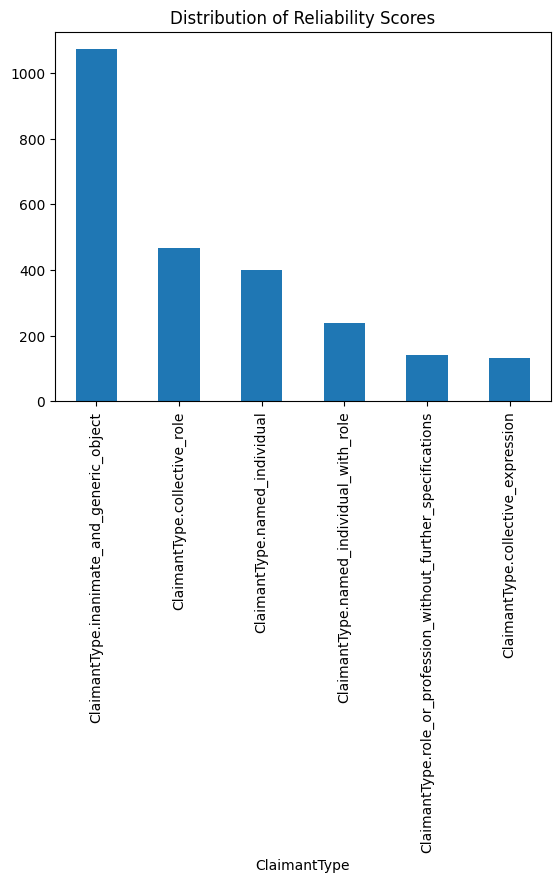

In [4]:
print(claimant_df['ClaimantType'].value_counts())

claimant_df['ClaimantType'].value_counts().plot(kind='bar', title='Distribution of Reliability Scores')

In [5]:
# load dataset
df = gather_dataset('./data/claimant_data_processed/')

claimant_df['claimant_type'] = claimant_df['ClaimantType'].apply(lambda type_: type_.name)
df = pd.merge(df, claimant_df[['task_id', 'claimant_type']], on='task_id')

df = z_score_per_task(df)
df = z_score_per_worker(df)

grouped_df = df.groupby(['source', 'claimant_type'], as_index=False).agg(
    {'score': 'mean', 'z_score_worker': 'mean', 'z_score_task': 'mean'}
)

print(f'There are {len(grouped_df)} different types of claimants')
grouped_df.head()

/home/bbjoverbeek/master_thesis/util.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(
/home/bbjoverbeek/master_thesis/util.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_scores_df = pd.concat(


There are 838 different types of claimants


,source,claimant_type,score,z_score_worker,z_score_task
0,' easytraveler ',inanimate_and_generic_object,2.330735,3.090821e-17,-0.501210
1,"( Keith Klugman , Emory University , personal ...",named_individual,3.488595,2.576088e-17,-0.045294
2,"( Michael Bruce , CDC , unpublished data )",inanimate_and_generic_object,3.955321,1.524731e-17,0.022773
3,"11 , no. 4 , August 1988 , pp. 304-9",inanimate_and_generic_object,0.962842,3.712119e-17,-0.132827
4,13 % of polled professional scientists,collective_role,2.875627,4.454255e-19,-0.116340


### Statistics

In [6]:
from scipy.stats import normaltest
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from typing import Literal

In [7]:
score_column: Literal['score', 'z_score_worker', 'z_score_task'] = 'score'

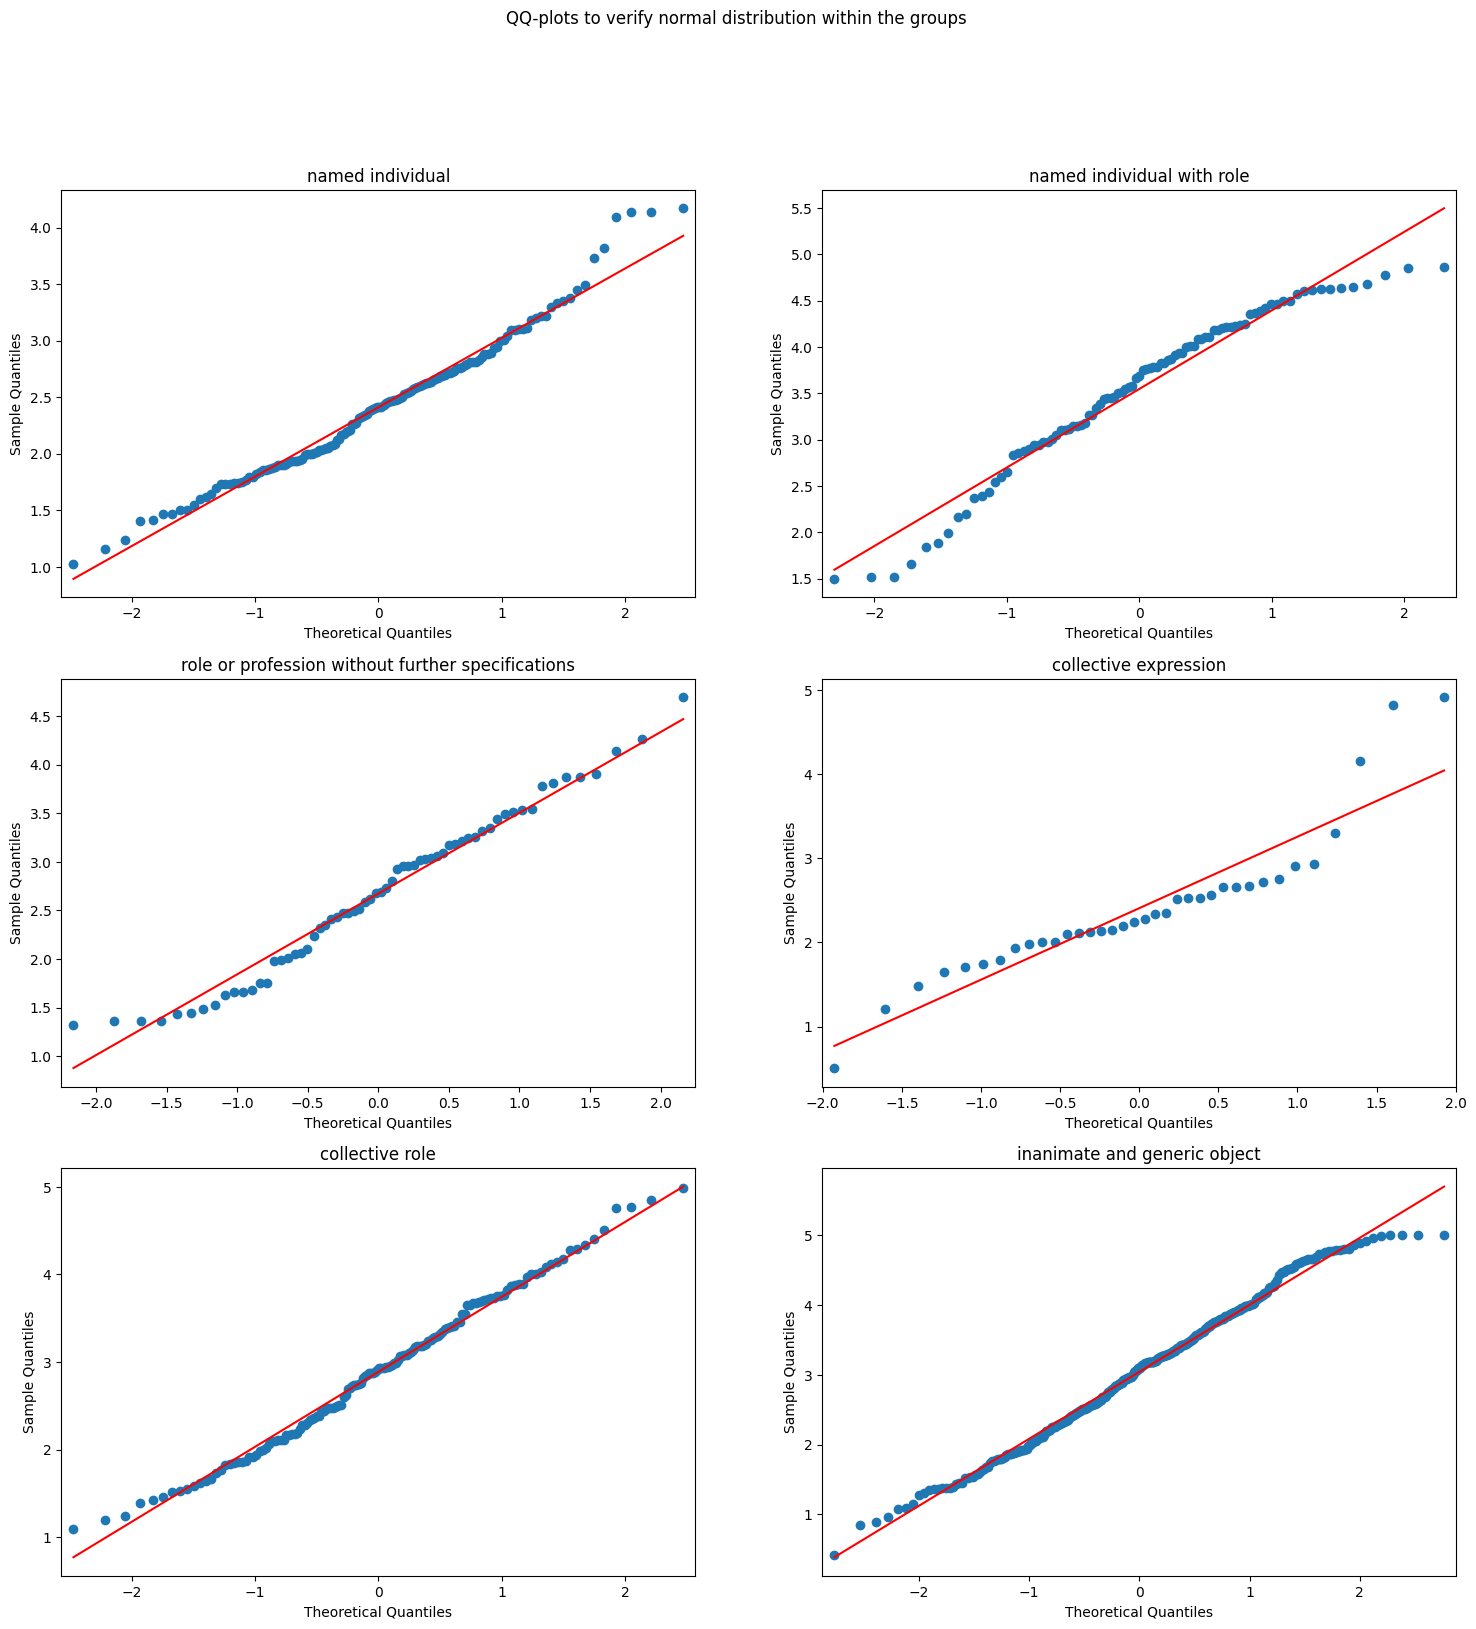

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(18,18))
fig.suptitle('QQ-plots to verify normal distribution within the groups')

linetype: Literal['s','45'] = 's'

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'named_individual'][score_column], line=linetype, ax=ax[0][0]) 
ax[0][0].set_title('named individual')

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'named_individual_with_role'][score_column], line=linetype, ax=ax[0][1]) 
ax[0][1].set_title('named individual with role')

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'role_or_profession_without_further_specifications'][score_column], line=linetype, ax=ax[1][0]) 
ax[1][0].set_title('role or profession without further specifications')

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'collective_expression'][score_column], line=linetype, ax=ax[1][1]) 
ax[1][1].set_title('collective expression')

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'collective_role'][score_column], line=linetype, ax=ax[2][0]) 
ax[2][0].set_title('collective role')

sm.qqplot(grouped_df[grouped_df['claimant_type'] == 'inanimate_and_generic_object'][score_column], line=linetype, ax=ax[2][1]) 
ax[2][1].set_title('inanimate and generic object')

plt.show()


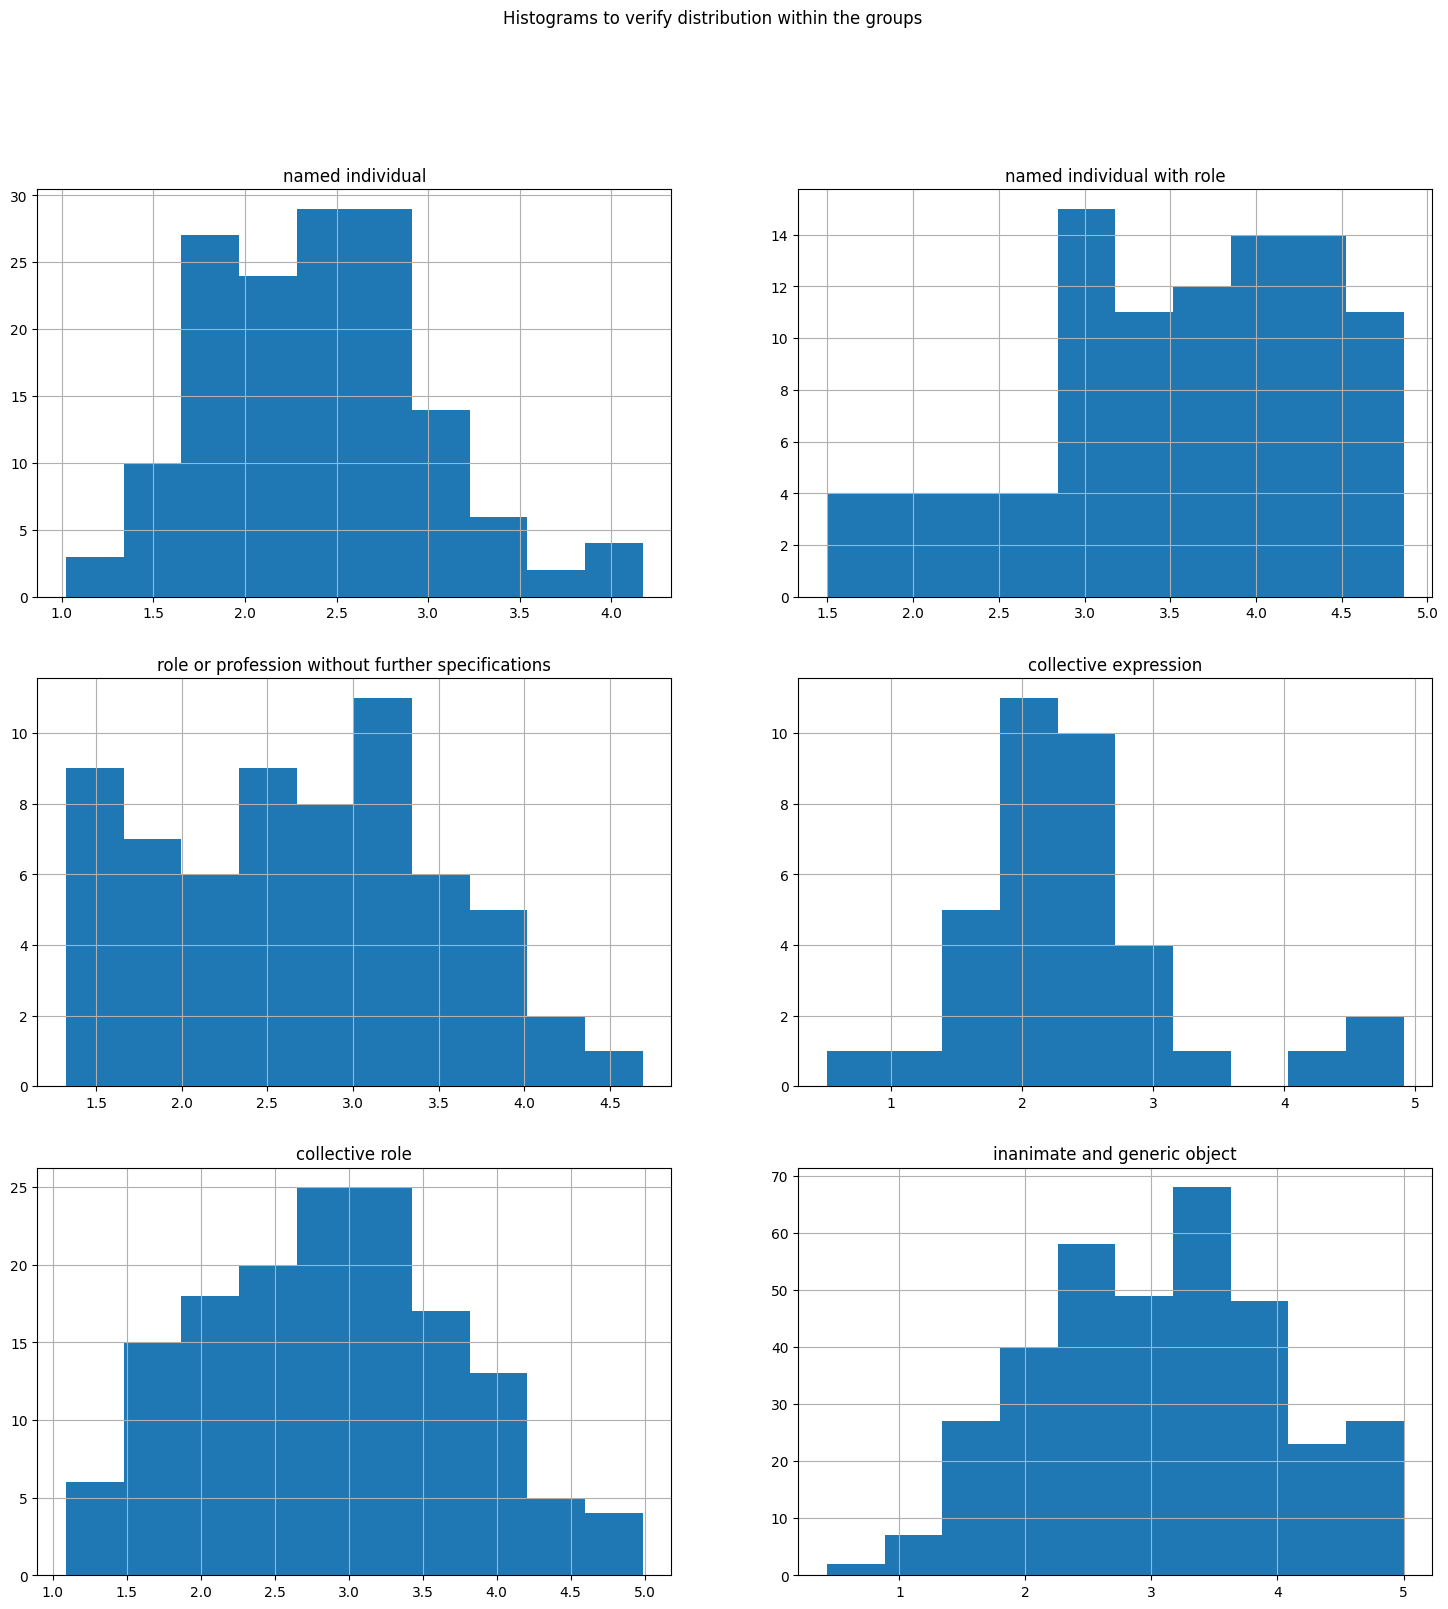

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(18,18))
fig.suptitle('Histograms to verify distribution within the groups')

grouped_df[grouped_df['claimant_type'] == 'named_individual'][score_column].hist(ax=ax[0][0]) 
ax[0][0].set_title('named individual')

grouped_df[grouped_df['claimant_type'] == 'named_individual_with_role'][score_column].hist(ax=ax[0][1]) 
ax[0][1].set_title('named individual with role')

grouped_df[grouped_df['claimant_type'] == 'role_or_profession_without_further_specifications'][score_column].hist(ax=ax[1][0]) 
ax[1][0].set_title('role or profession without further specifications')

grouped_df[grouped_df['claimant_type'] == 'collective_expression'][score_column].hist(ax=ax[1][1]) 
ax[1][1].set_title('collective expression')

grouped_df[grouped_df['claimant_type'] == 'collective_role'][score_column].hist(ax=ax[2][0]) 
ax[2][0].set_title('collective role')

grouped_df[grouped_df['claimant_type'] == 'inanimate_and_generic_object'][score_column].hist(ax=ax[2][1]) 
ax[2][1].set_title('inanimate and generic object')

plt.show()


In [55]:
# test for normal distribution within each group
alpha = 0.05
for idx in range(1, 7):
    print(f'{ClaimantType(idx).name:<50}', end='')
    result = normaltest(grouped_df[grouped_df['claimant_type'] == ClaimantType(idx).name][score_column])
    print(f'statistic: {result.statistic:<6.3f} - p-value: {result.pvalue:.3f}', end=' ')
    print(f'-> {"not normal" if result.pvalue < alpha else "normal"}')


named_individual                                  statistic: 7.314  - p-value: 0.026 -> not normal
named_individual_with_role                        statistic: 6.011  - p-value: 0.050 -> not normal
role_or_profession_without_further_specifications statistic: 3.008  - p-value: 0.222 -> normal
collective_expression                             statistic: 13.907 - p-value: 0.001 -> not normal
collective_role                                   statistic: 4.052  - p-value: 0.132 -> normal
inanimate_and_generic_object                      statistic: 9.098  - p-value: 0.011 -> not normal


<Axes: title={'center': 'score'}, xlabel='claimant_type'>

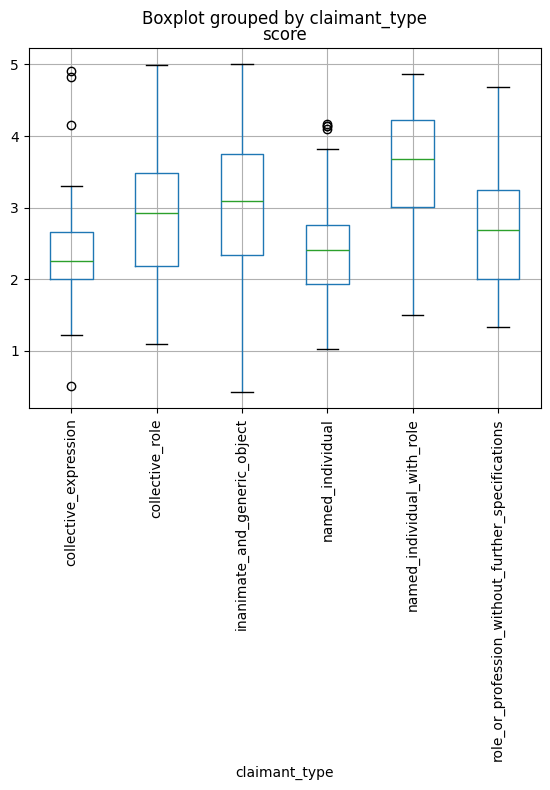

In [11]:
# create boxplot per category
grouped_df.boxplot(column=score_column, by='claimant_type', rot=90)

In [56]:
model = ols(f'{score_column} ~ C(claimant_type)', data=grouped_df).fit()

print(model.summary())

sm.stats.anova_lm(model, typ=1)

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     24.97
Date:                Tue, 25 Jun 2024   Prob (F-statistic):           1.68e-23
Time:                        12:47:27   Log-Likelihood:                -1064.6
No. Observations:                 838   AIC:                             2141.
Df Residuals:                     832   BIC:                             2169.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

,df,sum_sq,mean_sq,F,PR(>F)
C(claimant_type),5.0,93.440333,18.688067,24.974975,1.683894e-23
Residual,832.0,622.562039,0.748272,NaN,NaN


In [60]:
# run more robust Kruskal-Wallis H test in case is not normally distributed
from scipy.stats import kruskal

result = kruskal(grouped_df[grouped_df['claimant_type'] == 'named_individual'][score_column], grouped_df[grouped_df['claimant_type'] == 'named_individual_with_role'][score_column],grouped_df[grouped_df['claimant_type'] == 'role_or_profession_without_further_specifications'][score_column],grouped_df[grouped_df['claimant_type'] == 'collective_expression'][score_column],grouped_df[grouped_df['claimant_type'] == 'collective_role'][score_column],grouped_df[grouped_df['claimant_type'] == 'inanimate_and_generic_object'][score_column])
print(result)

alpha = 0.05
if result.pvalue < alpha:
    print('Reject null hypothesis -> there is a significant difference between claimant types')
else:
    print('Fail to reject null hypothesis -> there is _no_ significant difference between claimant types')

KruskalResult(statistic=113.79808016089753, pvalue=6.448816512757865e-23)
Reject null hypothesis -> there is a significant difference between claimant types


### Claimant types X Publisher types Heatmaps

In [23]:
# merge with publisher annotations
df = gather_flattened_dataset('./data/claimant_data_processed/flattened/')

publisher_df = pd.read_csv('./annotations/publisher_annotations.csv')
df = pd.merge(df, publisher_df, on='publisher')

df = pd.merge(df, claimant_df[['task_id', 'claimant_type']], on='task_id')

annotation_df = df[['task_id', 'claimant_type', 'category']]
del df

annotation_df = annotation_df.rename(columns={'category': 'publisher_type'}) #type:ignore
annotation_df['claimant_type'] = annotation_df['claimant_type'].apply(lambda type_: type_.replace('_', ' '))

annotation_df.head()

,task_id,claimant_type,publisher_type
0,f79dff90-7723-4c33-9582-33e46ab6176c,named individual with role,not established
1,f040bde3-4c11-482c-b7e3-4bd080b1a7f7,inanimate and generic object,established
2,e3f62e34-fb40-4bda-a5b4-acd3d72c1160,named individual with role,governmental/institutional
3,edf664b7-4b4b-4eca-8bfb-dbb814528de7,role or profession without further specifications,not established
4,cca66bf3-17a3-4c5d-8a91-ce303c7bc5a0,collective expression,established


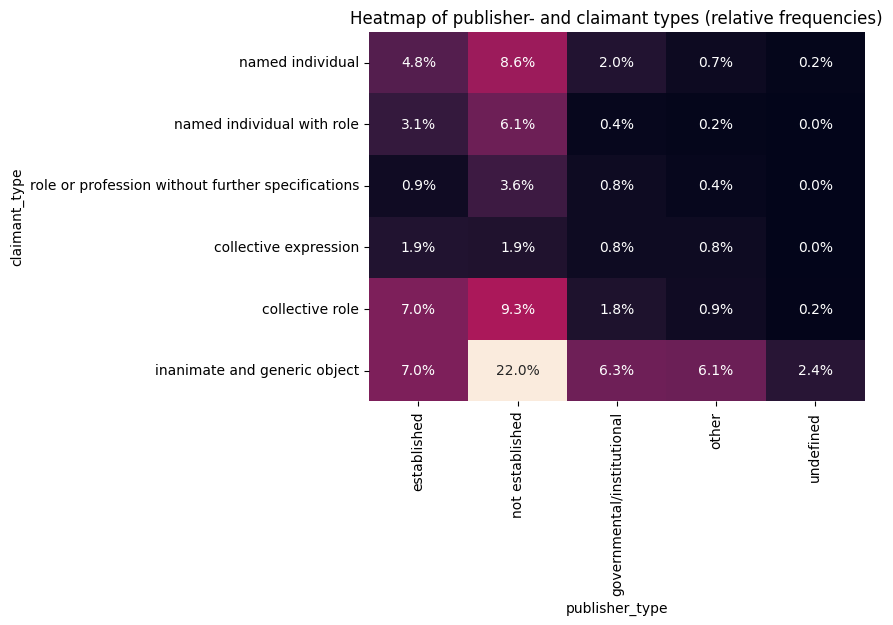

In [24]:
# heatmap with publisher and claimant categories
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize=True)
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies)')
plt.show()

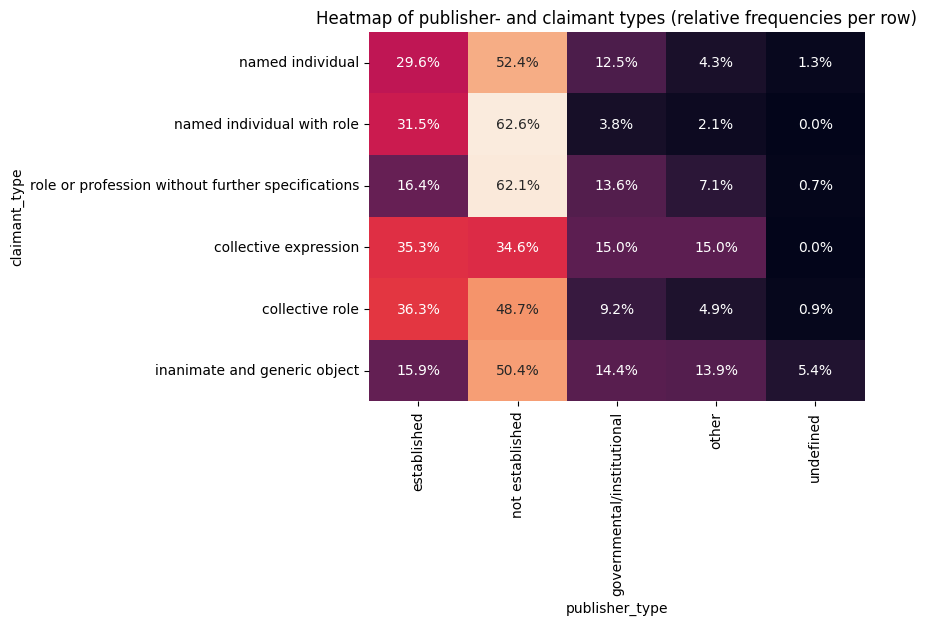

In [25]:
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize='index')
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies per row)')
plt.show()

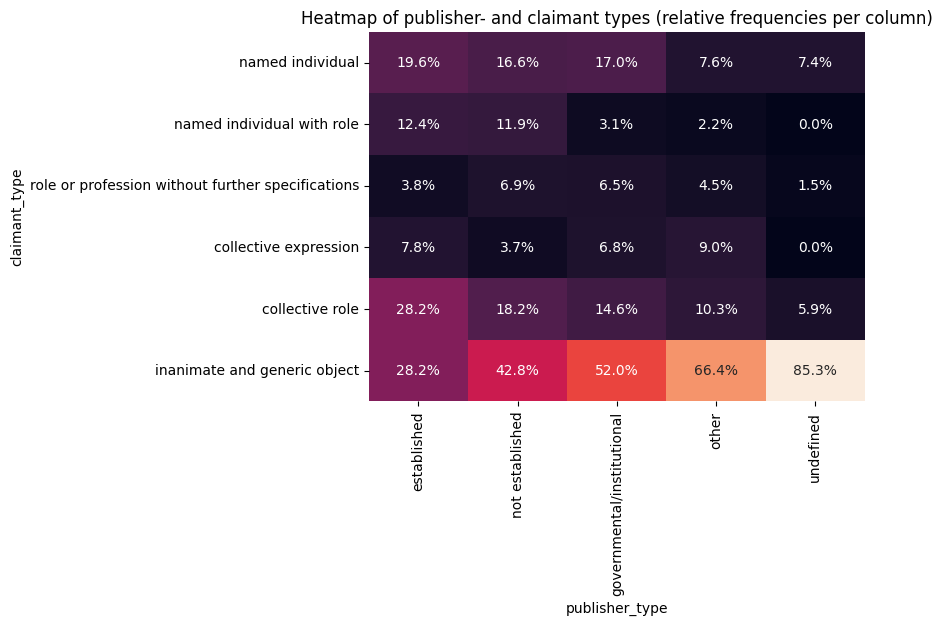

In [26]:
crosstab = pd.crosstab(annotation_df['claimant_type'], annotation_df['publisher_type'], normalize='columns')
crosstab = crosstab.reindex(['established' ,'not established', 'governmental/institutional', 'other', 'undefined'], axis='columns')
crosstab = crosstab.reindex(['named individual', 'named individual with role', 'role or profession without further specifications', 'collective expression', 'collective role', 'inanimate and generic object'], axis='index')

ax = sns.heatmap(crosstab, annot=True, fmt='.1%', cbar=False)

plt.title('Heatmap of publisher- and claimant types (relative frequencies per column)')
plt.show()